In [3]:
print("""
@Description: 线性回归的从零开始实现
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-05-14 14:34:02
"""
)


@Description: 线性回归的从零开始实现
@Author(s): Stephen CUI
@LastEditor(s): Stephen CUI
@CreatedTime: 2023-05-14 14:34:02



In [8]:
%matplotlib inline
import random
import torch
from torch import Tensor
from d2l import torch as d2l
from typing import Tuple

In [9]:
def synthetic_data(w : Tensor, b : float, num_samples:int=1000) -> Tuple[Tensor, Tensor]:
    """根据带有噪声的线性模型构造一个人造数据集

    Args:
        w (Tensor): 输入的权重张量
        b (float): 输入的偏置浮点数
        num_samples (int, optional): 样本点的数量. Defaults to 1000.

    Returns:
        Tuple[Tensor, Tensor]: 特征X和标签y
    """
    X = torch.normal(0, 1, (num_samples, len(w)))
    y = torch.matmul(X, w) + b
    y += torch.normal(0, .01, y.shape)
    return X, y.reshape((-1, 1))

In [10]:
true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b)

In [11]:
print('features:', features[0], '\nlabels: ', labels[0])

features: tensor([-0.3075,  0.7316]) 
labels:  tensor([1.1074])


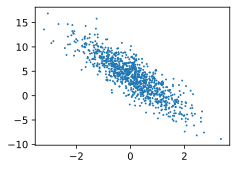

In [18]:
d2l.set_figsize()
d2l.plt.scatter(features[:,1].detach().numpy(),
                labels.detach().numpy(), 1) # 1 是size

In [20]:
def data_iter(batch_size: int, features:Tensor, labels:Tensor):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]


batch_size = 10
for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.1878,  0.4736],
        [-0.7781,  0.4333],
        [ 0.3255,  0.5628],
        [ 0.1093,  0.0630],
        [-3.0547, -0.0240],
        [-1.3866, -0.3039],
        [-0.0321,  0.5681],
        [-0.2786, -0.1550],
        [-0.0818,  0.1367],
        [ 1.1014, -1.0768]]) 
 tensor([[ 2.9655],
        [ 1.1742],
        [ 2.9483],
        [ 4.1936],
        [-1.8176],
        [ 2.4542],
        [ 2.1931],
        [ 4.1645],
        [ 3.5788],
        [10.0710]])


定义初始化模型参数

In [23]:
w = torch.normal(0, .01, size=(2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

定义模型

In [25]:
def lin_reg(X, w, b):
    """_summary_

    Args:
        X (_type_): _description_
        w (_type_): _description_
        b (_type_): _description_
    """
    return torch.matmul(X, w) + b

定义损失函数

In [26]:
def squared_loss(y_hat, y):
    """均方损失函数

    Args:
        y_hat (_type_): _description_
        y (_type_): _description_

    Returns:
        _type_: _description_
    """
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

In [29]:
def sgd(params, lr, batch_size: int):
    """小批量随机梯度下降

    Args:
        params (_type_): _description_
        lr (_type_): _description_
        batch_size (int): _description_
    """
    with torch.no_grad():
        for param in params:
            # 因为在损失函数中没有除以样本的数量，因此这里处理
            param -= lr * param.grad / batch_size
            param.grad.zero_()